## Libraries

In [38]:
import abc
import codecs
import inspect
import json
import logging
import gc
import os
import pickle
import random
import sys
import time
import warnings

import catboost as cat
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml

from abc import abstractmethod
from contextlib import contextmanager
from pathlib import Path
from typing import List, Optional, Union, Tuple, Dict, Sequence

from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm_notebook as tqdm

## Data Loading

In [2]:
DATA_DIR = Path("../features/")
train = pd.read_feather(DATA_DIR / "PastSummary_train.ftr")
valid = pd.read_feather(DATA_DIR / "PastSummary_valid.ftr")
test = pd.read_feather(DATA_DIR / "PastSummary_test.ftr")

In [4]:
len(set(test["installation_id"]) - set(valid["installation_id"]))

443

## First Assessment

In [5]:
all_ids = train["installation_id"].unique()

all_first_assess = []
after_second_assess = []

for idx in tqdm(all_ids):
    for i in range(5):
        assessments = train.query(
            f"installation_id == '{idx}' & session_title == {i}")
        if len(assessments) > 0:
            all_first_assess.append(assessments.iloc[0:1])
        if len(assessments) > 1:
            after_second_assess.append(assessments.iloc[1:])
            
            
all_first = pd.concat(
    all_first_assess,
    axis=0,
    sort=False).reset_index(drop=True)
after_second = pd.concat(
    after_second_assess,
    axis=0,
    sort=False).reset_index(drop=True)

In [6]:
all_first.head()

,Activity,Assessment,Clip,Game,3010,4035,2020,4100,3110,4070,...,Fireworks (Activity)_Dot_SoHigh_count,Flower Waterer (Activity)_duration,Sandcastle Builder (Activity)_duration,sand_filled_ratio,Sandcastle Builder (Activity)_Dot_DragShovel_count,Sandcastle Builder (Activity)_Dot_SoCool_count,Sandcastle Builder (Activity)_Dot_FillItUp_count,Watering Hole (Activity)_duration,water_filled_ratio,installation_id
0,4,1,8,4,226,6,26,5,223,156,...,12,164673,89767,0.500000,5,14,6,0,0.0,0006a69f
1,3,0,6,2,79,1,20,0,77,94,...,12,164673,89767,0.500000,5,14,6,0,0.0,0006a69f
2,7,2,11,5,246,45,50,5,240,577,...,0,267890,339403,0.492308,4,64,24,21389,0.0,0006c192
3,5,0,6,3,199,30,46,0,197,482,...,0,0,339403,0.492308,4,64,24,21389,0.0,0006c192
4,7,1,10,4,240,45,49,1,235,521,...,0,267890,339403,0.492308,4,64,24,21389,0.0,0006c192


In [9]:
all_first.shape

(9386, 978)

In [10]:
after_second.shape

(8304, 978)

## Config

In [12]:
conf_string = '''
dataset:
  dir: "input/data-science-bowl-2019/"
  feature_dir: "../features"
  params:

features:
  - PastSummary

av:
  split_params:
    n_splits: 5
    random_state: 42

  model_params:
    objective: "binary"
    metric: "auc"
    boosting: "gbdt"
    max_depth: 7
    num_leaves: 75
    learning_rate: 0.01
    colsample_bytree: 0.7
    subsample: 0.1
    subsample_freq: 1
    seed: 111
    feature_fraction_seed: 111
    drop_seed: 111
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 50000
    early_stopping_rounds: 200
    verbose_eval: 200

model:
  name: "lgbm"
  mode: "regression"
  sampling:
    name: "none"
    params:
      k_neighbors: 7
      n_jobs: 4
      random_state: 42
      acc_0_coef: 1.0
      acc_1_coef: 1.0
      acc_2_coef: 1.0
      acc_3_coef: 1.0

  model_params:
    objective: "regression"
    boosting_type: "gbdt"
    metric: "qwk"
    max_depth: -1
    num_leaves: 256
    tree_learner: "serial"
    learning_rate: 0.01
    subsample: 0.7
    subsample_freq: 1
    colsample_bytree: 0.5
    max_bin: 255
    seed: 71
    bagging_seed: 71
    feature_fraction_seed: 71
    drop_seed: 71
    verbose: -1
    n_jobs: -1
    first_metric_only: True

  train_params:
    num_boost_round: 10000
    early_stopping_rounds: 100
    verbose_eval: 100

post_process:
  params:
    reverse: False
    n_overall: 20
    n_classwise: 20

val:
  name: "group_kfold"
  n_delete:
  params:
    n_splits: 5
    random_state: 111

output_dir: "output"
'''

In [13]:
config = dict(yaml.load(conf_string, Loader=yaml.SafeLoader))

## Functions and Classes

### utils

#### jsonutil

In [14]:
class MyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(MyEncoder, self).default(obj)


def save_json(config: dict, save_path: Union[str, Path]):
    f = codecs.open(str(save_path), mode="w", encoding="utf-8")
    json.dump(config, f, indent=4, cls=MyEncoder, ensure_ascii=False)
    f.close()

#### logger

In [15]:
def configure_logger(config_name: str, log_dir: Union[Path, str], debug: bool):
    if isinstance(log_dir, str):
        Path(log_dir).mkdir(parents=True, exist_ok=True)
    else:
        log_dir.mkdir(parents=True, exist_ok=True)

    log_filename = config_name.split("/")[-1].replace(".yml", ".log")
    log_filepath = log_dir / log_filename \
        if isinstance(log_dir, Path) else Path(log_dir) / log_filename

    # delete the old log
    if log_filepath.exists():
        with open(log_filepath, mode="w"):
            pass

    level = logging.DEBUG if debug else logging.INFO
    logging.basicConfig(
        filename=str(log_filepath),
        level=level,
        format="%(asctime)s %(levelname)s %(message)s",
        datefmt="%m/%d/%Y %I:%M:%S %p")

#### timer

In [16]:
@contextmanager
def timer(name: str, log: bool = False):
    t0 = time.time()
    msg = f"[{name}] start"
    if not log:
        print(msg)
    else:
        logging.info(msg)
    yield

    msg = f"[{name}] done in {time.time() - t0:.2f} s"
    if not log:
        print(msg)
    else:
        logging.info(msg)

#### visualization

In [23]:
def plot_confusion_matrix(y_true,
                          y_pred,
                          classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          save_path: Path = Path("./")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(10, 10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, fontsize=25)
    plt.yticks(tick_marks, fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)
    plt.ylabel('True label', fontsize=25)
    plt.title(title, fontsize=30)

    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size="5%", pad=0.15)
    cbar = ax.figure.colorbar(im, ax=ax, cax=cax)
    cbar.ax.tick_params(labelsize=20)

    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        #            title=title,
        ylabel='True label',
        xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                fontsize=20,
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    plt.savefig(save_path)

### validation

In [17]:
def group_kfold(df: pd.DataFrame, groups: pd.Series,
                config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    params = config["val"]["params"]
    kf = KFold(
        n_splits=params["n_splits"],
        random_state=params["random_state"],
        shuffle=True)
    uniq_groups = groups.unique()
    split = []
    for trn_grp_idx, val_grp_idx in kf.split(uniq_groups):
        trn_grp = uniq_groups[trn_grp_idx]
        val_grp = uniq_groups[val_grp_idx]
        trn_idx = df[df["group"].isin(trn_grp)].index.values
        val_idx = df[df["group"].isin(val_grp)].index.values
        split.append((trn_idx, val_idx))

    return split


def get_validation(df: pd.DataFrame,
                   config: dict) -> List[Tuple[np.ndarray, np.ndarray]]:
    name: str = config["val"]["name"]

    func = globals().get(name)
    if func is None:
        raise NotImplementedError

    if "group" in name:
        groups = df["group"]
        return func(df, groups, config)
    else:
        return func(df, config)

#### feature_selection

In [18]:
def select_features(cols: List[str], feature_importance: pd.DataFrame,
                    config: dict) -> List[str]:
    if config["val"].get("n_delete") is None:
        return cols

    n_delete = config["val"].get("n_delete")
    importance_sorted_cols = feature_importance.sort_values(
        by="value", ascending=False)["feature"].tolist()
    if isinstance(n_delete, int):
        remove_cols = importance_sorted_cols[:n_delete]
        for col in remove_cols:
            cols.remove(col)
    elif isinstance(n_delete, float):
        n_delete_int = int(n_delete * len(importance_sorted_cols))
        remove_cols = importance_sorted_cols[:n_delete_int]
        for col in remove_cols:
            cols.remove(col)
    return cols

### evaluation

In [19]:
def qwk(y_true: Union[np.ndarray, list],
        y_pred: Union[np.ndarray, list],
        max_rat: int = 3) -> float:
    y_true_ = np.asarray(y_true)
    y_pred_ = np.asarray(y_pred)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    uniq_class = np.unique(y_true_)
    for i in uniq_class:
        hist1[int(i)] = len(np.argwhere(y_true_ == i))
        hist2[int(i)] = len(np.argwhere(y_pred_ == i))

    numerator = np.square(y_true_ - y_pred_).sum()

    denominator = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            denominator += hist1[i] * hist2[j] * (i - j) * (i - j)

    denominator /= y_true_.shape[0]
    return 1 - numerator / denominator


def calc_metric(y_true: Union[np.ndarray, list],
                y_pred: Union[np.ndarray, list]) -> float:
    return qwk(y_true, y_pred)

#### optimization

In [24]:
class OptimizedRounder(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.coef = [0.25, 0.5, 0.75]
        self.reverse = reverse

    def _loss(self, X: np.ndarray, y: np.ndarray) -> float:
        X_p = np.digitize(X, self.coef)
        ll = -calc_metric(y, X_p)
        return ll

    def fit(self, X: np.ndarray, y: np.ndarray):
        golden1 = 0.618
        golden2 = 1 - golden1
        ab_start = [(0.01, 0.4), (0.4, 0.7), (0.7, 0.9)]
        for _ in range(self.n_overall):
            if self.reverse:
                search = reversed(range(3))
            else:
                search = iter(range(3))
            for idx in search:
                # golden section search
                a, b = ab_start[idx]
                # calc losses
                self.coef[idx] = a
                la = self._loss(X, y)
                self.coef[idx] = b
                lb = self._loss(X, y)
                for it in range(self.n_classwise):
                    # choose value
                    if la > lb:
                        a = b - (b - a) * golden1
                        self.coef[idx] = a
                        la = self._loss(X, y)
                    else:
                        b = b - (b - a) * golden2
                        self.coef[idx] = b
                        lb = self._loss(X, y)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X_p = np.digitize(X, self.coef)
        return X_p

#### cat

In [25]:
class CatBoostOptimizedQWKMetric(object):
    def __init__(self,
                 n_overall: int = 5,
                 n_classwise: int = 5,
                 reverse: bool = False):
        self.n_overall = n_overall
        self.n_classwise = n_classwise
        self.reverse = reverse

    def get_final_error(self, error: float, weight: float) -> float:
        return error / (weight + 1e-38)

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target,
                 weight: Optional[Sequence[float]]) -> Tuple[float, float]:
        assert len(approxes) == 1
        assert len(target) == len(approxes[0])

        approx = approxes[0]
        approx_np = np.array(approx)
        target_np = (np.array(target) * 3).astype(int)

        OptR = OptimizedRounder(
            n_classwise=self.n_classwise,
            n_overall=self.n_overall,
            reverse=self.reverse)
        OptR.fit(approx_np, target_np)

        y_pred = OptR.predict(approx_np).astype(int)
        y_true = target_np.astype(int)

        weight_sum = 1.0
        qwk = calc_metric(y_true, y_pred)
        return qwk, weight_sum

#### lgbm

In [26]:
def lgb_classification_qwk(y_pred: np.ndarray,
                           data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = data.get_label()
    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return "qwk", calc_metric(y_true, y_pred), True


def lgb_regression_qwk(y_pred: np.ndarray,
                       data: lgb.Dataset) -> Tuple[str, float, bool]:
    y_true = (data.get_label() * 3).astype(int)
    y_pred = y_pred.reshape(-1)

    OptR = OptimizedRounder(n_classwise=5, n_overall=5)
    OptR.fit(y_pred, y_true)

    y_pred = OptR.predict(y_pred).astype(int)
    qwk = calc_metric(y_true, y_pred)

    return "qwk", qwk, True


def lgb_residual_qwk_closure(mean_target: np.ndarray):
    def lgb_residual_qwk(y_pred: np.ndarray,
                         data: lgb.Dataset) -> Tuple[str, float, bool]:
        y_true = (data.get_label() * 3).astype(int)
        y_pred = y_pred.reshape(-1)

        y_true = (y_true + mean_target).astype(int)
        y_pred = y_pred + mean_target

        OptR = OptimizedRounder(n_classwise=5, n_overall=5)
        OptR.fit(y_pred, y_true)

        y_pred = OptR.predict(y_pred).astype(int)
        qwk = calc_metric(y_true, y_pred)

        return "qwk", qwk, True

    return lgb_residual_qwk

### models

#### base

In [27]:
# type alias
AoD = Union[np.ndarray, pd.DataFrame]
AoS = Union[np.ndarray, pd.Series]
CatModel = Union[cat.CatBoostClassifier, cat.CatBoostRegressor]
LGBModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]
Model = Union[CatModel, LGBModel]


class BaseModel(object):
    @abstractmethod
    def fit(self, x_train: AoD, y_train: AoS, x_valid: AoD, y_valid: AoS,
            config: dict) -> Tuple[Model, dict]:
        raise NotImplementedError

    @abstractmethod
    def get_best_iteration(self, model: Model) -> int:
        raise NotImplementedError

    @abstractmethod
    def predict(self, model: Model, features: AoD) -> np.ndarray:
        raise NotImplementedError

    @abstractmethod
    def get_feature_importance(self, model: Model) -> np.ndarray:
        raise NotImplementedError

    def post_process(self, oof_preds: np.ndarray, y: np.ndarray, 
                     config: dict
                     ) -> Tuple[np.ndarray, np.ndarray, Optional[np.ndarray]]:
        return oof_preds

    def cv(self,
           y_train: AoS,
           train_features: AoD,
           feature_name: List[str],
           folds_ids: List[Tuple[np.ndarray, np.ndarray]],
           config: dict,
           log: bool = True
           ) -> Tuple[List[Model], np.ndarray, np.
                      ndarray, Optional[np.ndarray], pd.DataFrame, dict]:
        # initialize
        oof_preds = np.zeros(len(train_features))
        importances = pd.DataFrame(index=feature_name)
        best_iteration = 0.0
        cv_score_list: List[dict] = []
        models: List[Model] = []

        X = train_features.values if isinstance(train_features, pd.DataFrame) \
            else train_features
        y = y_train.values if isinstance(y_train, pd.Series) \
            else y_train

        for i_fold, (trn_idx, val_idx) in enumerate(folds_ids):
            self.fold = i_fold
            # get train data and valid data
            x_trn = X[trn_idx]
            y_trn = y[trn_idx]
            x_val = X[val_idx]
            y_val = y[val_idx]

            # train model
            model, best_score = self.fit(
                x_trn, y_trn, x_val, y_val, config=config)
            cv_score_list.append(best_score)
            models.append(model)
            best_iteration += self.get_best_iteration(model) / len(folds_ids)

            # predict oof and test
            oof_preds[val_idx] = self.predict(model, x_val).reshape(-1)

            # get feature importances
            importances_tmp = pd.DataFrame(
                self.get_feature_importance(model),
                columns=[f"gain_{i_fold+1}"],
                index=feature_name)
            importances = importances.join(importances_tmp, how="inner")

        # summary of feature importance
        feature_importance = importances.mean(axis=1)

        # save raw prediction
        self.raw_oof_preds = oof_preds

        # post_process (if you have any)
        oof_preds = self.post_process(
            oof_preds, y_train, config)

        # print oof score
        oof_score = calc_metric(y_train, oof_preds)
        print(f"oof score: {oof_score:.5f}")

        if log:
            logging.info(f"oof score: {oof_score:.5f}")

        evals_results = {
            "evals_result": {
                "oof_score":
                oof_score,
                "cv_score": {
                    f"cv{i + 1}": cv_score
                    for i, cv_score in enumerate(cv_score_list)
                },
                "n_data":
                len(train_features),
                "best_iteration":
                best_iteration,
                "n_features":
                len(train_features.columns),
                "feature_importance":
                feature_importance.sort_values(ascending=False).to_dict()
            }
        }
        return (models, oof_preds, feature_importance, evals_results)

#### lgbm

In [33]:
LGBMModel = Union[lgb.LGBMClassifier, lgb.LGBMRegressor]


class LightGBM(BaseModel):
    def fit(self, x_train: np.ndarray, y_train: np.ndarray,
            x_valid: np.ndarray, y_valid: np.ndarray,
            config: dict) -> Tuple[LGBMModel, dict]:
        model_params = config["model"]["model_params"]
        train_params = config["model"]["train_params"]

        mode = config["model"]["mode"]
        self.mode = mode
        if mode == "regression":
            self.denominator = y_train.max()
            y_train = y_train / self.denominator
            y_valid = y_valid / self.denominator

        d_train = lgb.Dataset(x_train, label=y_train)
        d_valid = lgb.Dataset(x_valid, label=y_valid)

        valid_sets: List[lgb.Dataset] = []
        valid_names: List[str] = []
        valid_sets.append(d_valid)
        valid_names.append("valid")

        if mode == "regression":
            feval = lgb_regression_qwk if (mode == "regression") else None
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=feval,  # FIXME: support for residual
                **train_params)
        else:
            model = lgb.train(
                params=model_params,
                train_set=d_train,
                valid_sets=valid_sets,
                valid_names=valid_names,
                feval=lgb_classification_qwk,
                **train_params)
        best_score = dict(model.best_score)
        return model, best_score

    def get_best_iteration(self, model: LGBMModel) -> int:
        return model.best_iteration

    def predict(self, model: LGBMModel,
                features: Union[pd.DataFrame, np.ndarray]) -> np.ndarray:
        if self.mode == "regression":
            return model.predict(features)
        else:
            return model.predict(features).reshape(4, -1).argmax(axis=0)

    def get_feature_importance(self, model: LGBMModel) -> np.ndarray:
        return model.feature_importance(importance_type="gain")

    def post_process(self, oof_preds: np.ndarray, y_train: np.ndarray,
                     config: dict
                     ) -> np.ndarray:
        # Override
        if self.mode == "regression":
            params = config["post_process"]["params"]
            OptR = OptimizedRounder(**params)
            OptR.fit(oof_preds, y_train)
            oof_preds_ = OptR.predict(oof_preds)
            
            return oof_preds_
        return oof_preds

#### factory

In [34]:
def lgbm() -> LightGBM:
    return LightGBM()


def get_model(config: dict):
    model_name = config["model"]["name"]
    func = globals().get(model_name)
    if func is None:
        raise NotImplementedError
    return func()

## Main

### settings

In [30]:
warnings.filterwarnings("ignore")

# argsの代わり
debug = True
config_path = "../config/lgb_xx.yml"
log_dir = "log/"

configure_logger(config_path, log_dir, debug)

logging.info(f"config: {config_path}")
logging.info(f"debug: {debug}")

config["args"] = dict()
config["args"]["config"] = config_path

# make output dir
output_root_dir = Path(config["output_dir"])
feature_dir = Path(config["dataset"]["feature_dir"])

config_name: str = config_path.split("/")[-1].replace(".yml", "")
output_dir = output_root_dir / config_name
output_dir.mkdir(parents=True, exist_ok=True)

logging.info(f"model output dir: {str(output_dir)}")

config["model_output_dir"] = str(output_dir)

In [43]:
x_train0 = all_first

groups0 = x_train0["installation_id"].values
y_train0 = x_train0["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train0.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train0 = x_train0[cols]

assert len(x_train0) == len(y_train0)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train0)}")

### Train model

Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.519722
[200]	valid's qwk: 0.568231
[300]	valid's qwk: 0.580614
[400]	valid's qwk: 0.577759
Early stopping, best iteration is:
[331]	valid's qwk: 0.585023
Evaluated only: qwk
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.508661
[200]	valid's qwk: 0.559397
[300]	valid's qwk: 0.568369
[400]	valid's qwk: 0.571893
[500]	valid's qwk: 0.573399
Early stopping, best iteration is:
[478]	valid's qwk: 0.577933
Evaluated only: qwk
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.508478
[200]	valid's qwk: 0.54561
[300]	valid's qwk: 0.555777
[400]	valid's qwk: 0.555333
Early stopping, best iteration is:
[320]	valid's qwk: 0.564158
Evaluated only: qwk
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.510135
[200]	valid's qwk: 0.551964
[300]	valid's qwk: 0.562862
Early stopping, best iteration is:
[298]	valid's qwk: 0.

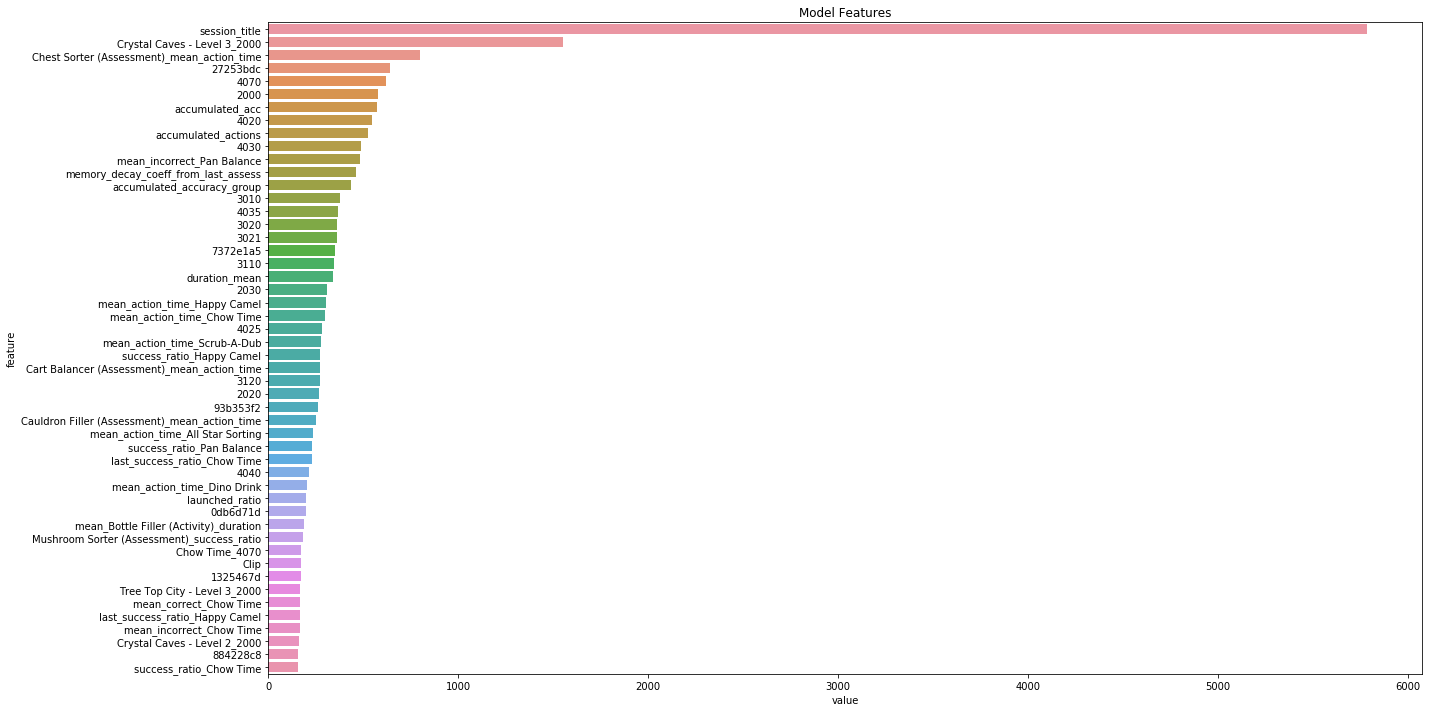

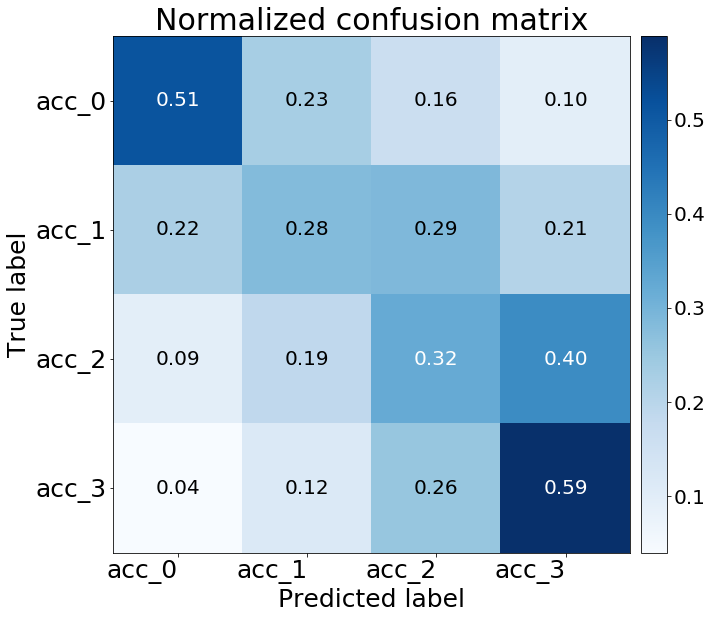

In [45]:
logging.info("Only First")

# get folds
x_train0["group"] = groups0
splits = get_validation(x_train0, config)
x_train0.drop("group", axis=1, inplace=True)

model = get_model(config)
models, oof_preds0, feature_importance, eval_results = model.cv(
    y_train0,
    x_train0[cols],
    feature_name=cols,
    folds_ids=splits,
    config=config,
    log=True)

config["eval_results"] = dict()
for k, v in eval_results.items():
    config["eval_results"][k] = v

feature_imp = feature_importance.reset_index().rename(columns={
    "index": "feature",
    0: "value"
})
plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_model.png")

# Confusion Matrix
plot_confusion_matrix(
    y_train0,
    oof_preds0,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")

In [46]:
x_train1 = after_second

groups1 = x_train1["installation_id"].values
y_train1 = x_train1["accuracy_group"].values.reshape(-1)
cols: List[str] = x_train1.columns.tolist()
cols.remove("installation_id")
cols.remove("accuracy_group")
x_train1 = x_train1[cols]

assert len(x_train1) == len(y_train1)
logging.debug(f"number of features: {len(cols)}")
logging.debug(f"number of train samples: {len(x_train1)}")

Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.620519
[200]	valid's qwk: 0.656465
[300]	valid's qwk: 0.662322
[400]	valid's qwk: 0.665162
[500]	valid's qwk: 0.665015
Early stopping, best iteration is:
[409]	valid's qwk: 0.670785
Evaluated only: qwk
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.556755
[200]	valid's qwk: 0.573452
[300]	valid's qwk: 0.583468
[400]	valid's qwk: 0.591438
[500]	valid's qwk: 0.589846
Early stopping, best iteration is:
[406]	valid's qwk: 0.593554
Evaluated only: qwk
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.573063
[200]	valid's qwk: 0.601867
[300]	valid's qwk: 0.604851
[400]	valid's qwk: 0.604073
Early stopping, best iteration is:
[332]	valid's qwk: 0.60846
Evaluated only: qwk
Training until validation scores don't improve for 100 rounds
[100]	valid's qwk: 0.585545
[200]	valid's qwk: 0.627039
[300]	valid's qwk: 0.629199
Early stopping, best iterati

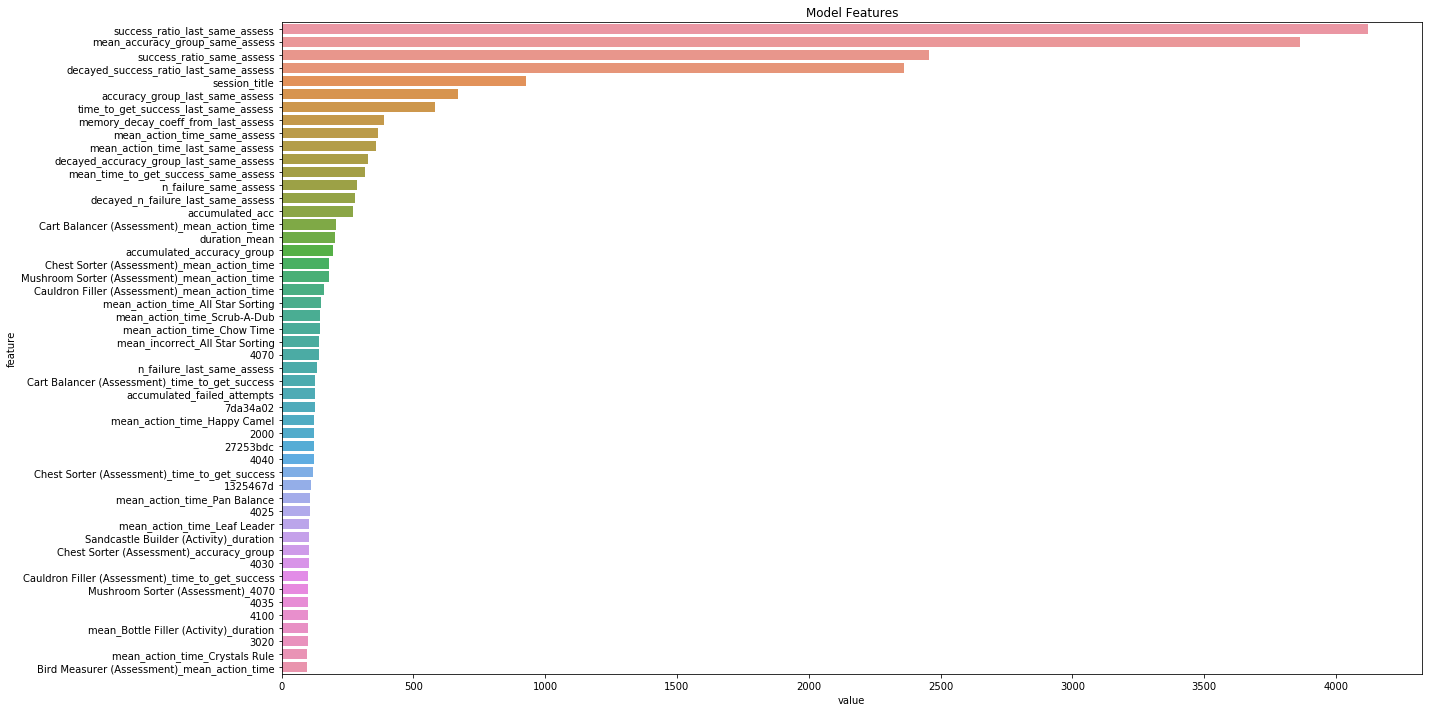

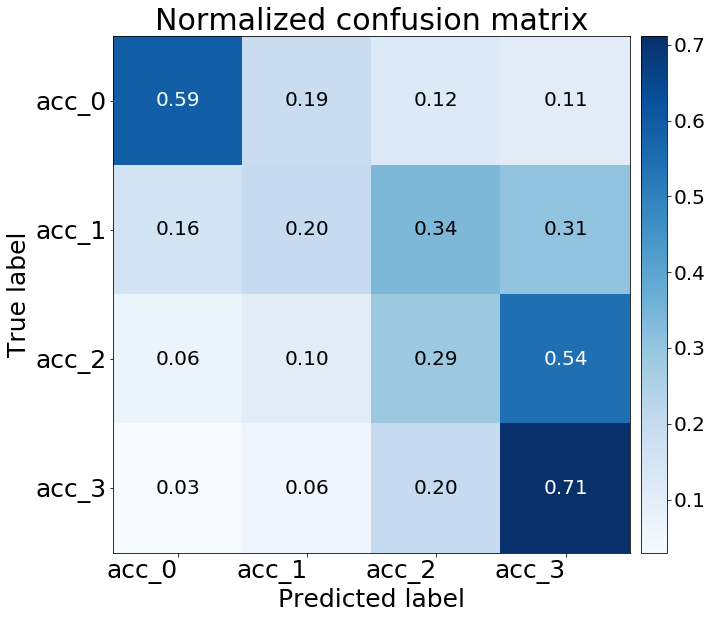

In [47]:
logging.info("Only First")

# get folds
x_train1["group"] = groups1
splits = get_validation(x_train1, config)
x_train1.drop("group", axis=1, inplace=True)

model = get_model(config)
models, oof_preds1, feature_importance, eval_results = model.cv(
    y_train1,
    x_train1[cols],
    feature_name=cols,
    folds_ids=splits,
    config=config,
    log=True)

config["eval_results"] = dict()
for k, v in eval_results.items():
    config["eval_results"][k] = v

feature_imp = feature_importance.reset_index().rename(columns={
    "index": "feature",
    0: "value"
})
plt.figure(figsize=(20, 10))
sns.barplot(
    x="value",
    y="feature",
    data=feature_imp.sort_values(by="value", ascending=False).head(50))
plt.title("Model Features")
plt.tight_layout()
plt.savefig(output_dir / "feature_importance_model.png")

# Confusion Matrix
plot_confusion_matrix(
    y_train1,
    oof_preds1,
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")

In [48]:
qwk_score = qwk(
    np.concatenate([
        oof_preds0,
        oof_preds1
    ]),
    np.concatenate([
        y_train0,
        y_train1
    ])
)
print(f"overall qwk: {qwk_score:.4f}")

overall qwk: 0.5949


Normalized confusion matrix
[[0.54291795 0.21163396 0.14566091 0.09978718]
 [0.19245127 0.24305268 0.31107424 0.25342182]
 [0.07981859 0.14739229 0.30521542 0.4675737 ]
 [0.03470888 0.08773318 0.22803844 0.6495195 ]]


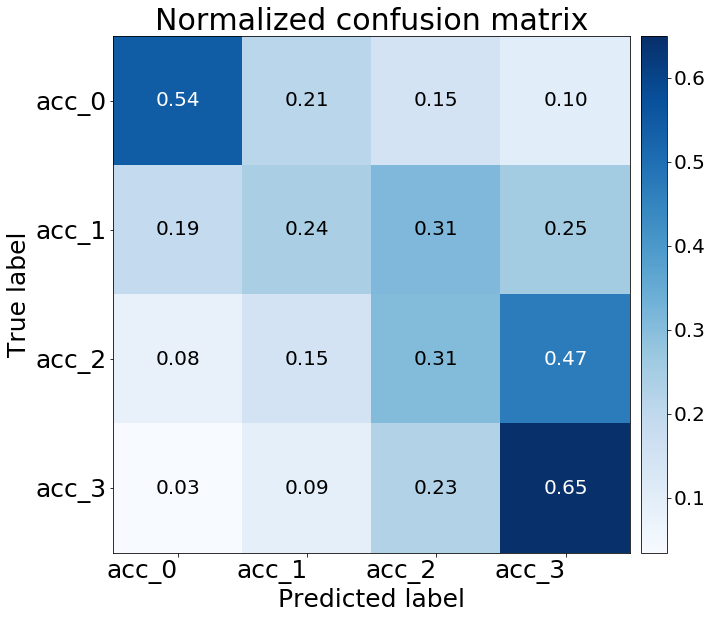

In [49]:
# Confusion Matrix
plot_confusion_matrix(
    np.concatenate([
        y_train0,
        y_train1
    ]),
    np.concatenate([
        oof_preds0,
        oof_preds1
    ]),
    classes=np.array(["acc_0", "acc_1", "acc_2", "acc_3"]),
    normalize=True,
    save_path=output_dir / "confusion_matrix_oof.png")